In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim, feature_scoring, dimensional_stacking
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
from SALib.analyze.sobol import analyze
from plotting_function import customize_save_and_show_plot

# Open Exploration

## Introduction

This notebook demonstrates an open exploration and a sensitivity analysis of simulation outputs related to dike modeling. The objective is to analyze the impacts of different policies and scenarios on various outcomes that Water Board 1 is interested in. The analysis is based on data generated through three different sampling methods: random policy and scenario sampling,random scenario sampling where policy remains unchanged, and Sobol sensitivity sampling. These experiments and their corresponding outcomes were created in the script `Step1_Simulate_Open_Exploration.py`.

- **Random Policy and Scenario Sampling**: This method explores a wide range of combinations of policies (lever settings) and scenarios (uncertainty conditions). It helps in understanding the diverse potential outcomes and behaviors of the model under different random conditions.
- **Scenario Sampling with Unchanged Policies**: In this method the current policy is maintained while exploring a wide range of scenarios (combinations of uncertainties). This serves as a reference point for comparing the effects of different uncertainties under a fixed policy.
- **Sobol Sensitivity Sampling**: Utilizes Sobol sampling to determine the influence of uncertainties on the model outputs. This technique is crucial for identifying the most impactful uncertainties and understanding their interactions under a systematic exploration of scenario combinations.


The notebook is structured to provide a clear and detailed analysis, which includes the following steps:

**Loading CSVs (Simulation Outputs)**:
We start by loading the simulation output data from CSV files generated by the different sampling methods mentioned above.

1. **Descriptives**


2. **Exploratory Analysis with No Policy**:
    2.1. **Pairplot of Outputs**: Visualize the relationships between different outcome variables using pairplots.
    2.3. **Feature Scoring**: Assess the importance of different features using feature scoring methods.
    2.3. **Dimensional Stacking**: Apply dimensional stacking to understand the multi-dimensional interactions between features and outcomes.
    2.4. **PRIM (Patient Rule Induction Method)**: Use PRIM to identify and analyze regions in the data that lead to certain outcomes.

3. **Exploratory Analysis with Multiple Policies**:
    2.1. **Pairplot of Outputs**: Visualize the relationships between different outcome variables using pairplots.
    2.3. **Feature Scoring**: Assess the importance of different features using feature scoring methods.
    2.3. **Dimensional Stacking**: Apply dimensional stacking to understand the multi-dimensional interactions between features and outcomes.
    2.4. **PRIM (Patient Rule Induction Method)**: Use PRIM to identify and analyze regions in the data that lead to certain outcomes.

4. **Sensitivity Analysis (Sobol)**:
    Perform a Sobol sensitivity analysis to determine the influence of uncertainties on the model outputs. This helps in understanding which uncertainties significantly impact the outcomes and how they interact.

## Let us first load the CSVs
We load the saved CSV files into pandas DataFrames. These files contain the data from the random policy analyses, no policy scenario analyses, Sobol sensitivity analyses.

In [35]:
# Specify directory where CSVs are located
input_dir = os.path.join('data', 'output_data')

# Load the saved CSV files into variables
random_experiments_df = pd.read_csv(os.path.join(input_dir, 'random_experiments.csv'))
random_outcomes_df = pd.read_csv(os.path.join(input_dir, 'random_outcomes.csv'))
sobol_experiments_df = pd.read_csv(os.path.join(input_dir, 'sobol_experiments.csv'))
sobol_outcomes_df = pd.read_csv(os.path.join(input_dir, 'sobol_outcomes.csv'))
no_policy_experiments_df = pd.read_csv(os.path.join(input_dir, 'no_policy_experiments.csv'))
no_policy_outcomes_df = pd.read_csv(os.path.join(input_dir, 'no_policy_outcomes.csv'))

To ensure that the DataFrames are clean and only contain relevant data, we drop unnecessary columns that were automatically created during the CSV saving process.

In [36]:
# Load the saved CSV files into variables
random_experiments_df = random_experiments_df.drop(columns='Unnamed: 0')
random_outcomes_df = random_outcomes_df.drop(columns='Unnamed: 0')
sobol_experiments_df = sobol_experiments_df.drop(columns='Unnamed: 0')
sobol_outcomes_df = sobol_outcomes_df.drop(columns='Unnamed: 0')
no_policy_experiments_df = no_policy_experiments_df.drop(columns='Unnamed: 0')
no_policy_outcomes_df = no_policy_outcomes_df.drop(columns='Unnamed: 0')


We inspect the data by printing the contents of the random experiments and outcomes DataFrames. This step helps us understand the structure and content of the data.

In [37]:
print(random_outcomes_df.columns) 

Index(['A.4_Expected Annual Damage', 'A.4_Dike Investment Costs',
       'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage',
       'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths',
       'Combined_Expected Annual Damage', 'Combined_Dike Investment Costs',
       'Combined_Expected Number of Deaths', 'policy'],
      dtype='object')


In [40]:
random_outcomes_combined = random_outcomes_df[['Combined_Expected Annual Damage', 'Combined_Dike Investment Costs',
       'Combined_Expected Number of Deaths', 'policy']]
random_outcomes_separate = random_outcomes_df[['A.4_Expected Annual Damage', 'A.4_Dike Investment Costs',
       'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage',
       'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'policy']]

no_policy_combined = no_policy_outcomes_df[['Combined_Expected Annual Damage', 'Combined_Dike Investment Costs',
       'Combined_Expected Number of Deaths']]
no_policy_separate = no_policy_outcomes_df[['A.4_Expected Annual Damage', 'A.4_Dike Investment Costs',
       'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage',
       'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths']]

sobol_combined = sobol_outcomes_df[['Combined_Expected Annual Damage', 'Combined_Dike Investment Costs',
       'Combined_Expected Number of Deaths']]
sobol_separate = sobol_outcomes_df[['A.4_Expected Annual Damage', 'A.4_Dike Investment Costs',
       'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage',
       'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths']]

# 1. Descriptives
We will now look at descriptives of the runs with no policy and the runs with X policies. To look at the potential spread of the variables, related to the objectives.

In [5]:
print(no_policy_outcomes_df, random_outcomes_df)

      A.4_Expected Annual Damage  A.4_Dike Investment Costs  \
0                   5.031780e+07                          0   
1                   0.000000e+00                          0   
2                   0.000000e+00                          0   
3                   0.000000e+00                          0   
4                   0.000000e+00                          0   
...                          ...                        ...   
9995                1.821713e+08                          0   
9996                0.000000e+00                          0   
9997                0.000000e+00                          0   
9998                0.000000e+00                          0   
9999                1.296538e+07                          0   

      A.4_Expected Number of Deaths  A.5_Expected Annual Damage  \
0                          0.020830                1.041886e+07   
1                          0.000000                0.000000e+00   
2                          0.000000       

Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\data\plots\Violin Plot of Combined_Expected Number of Deaths.png


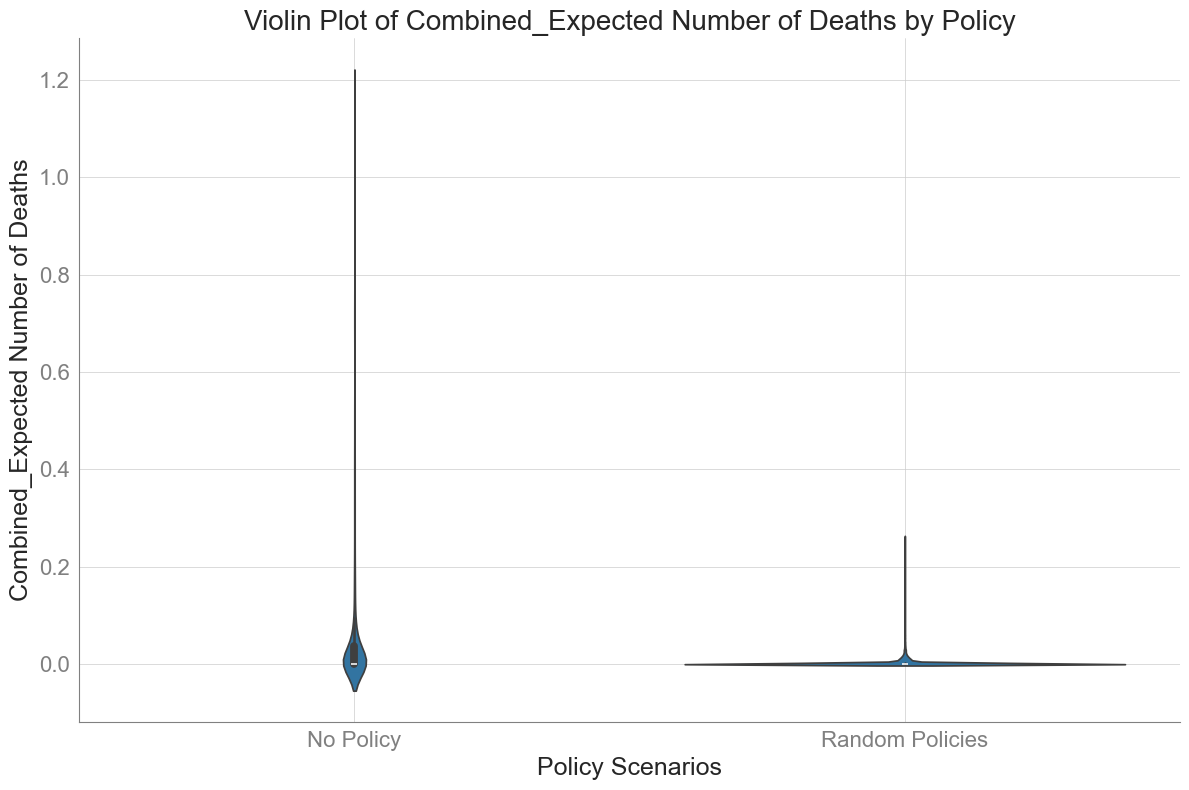

Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\data\plots\Violin Plot of Combined_Dike Investment Costs.png


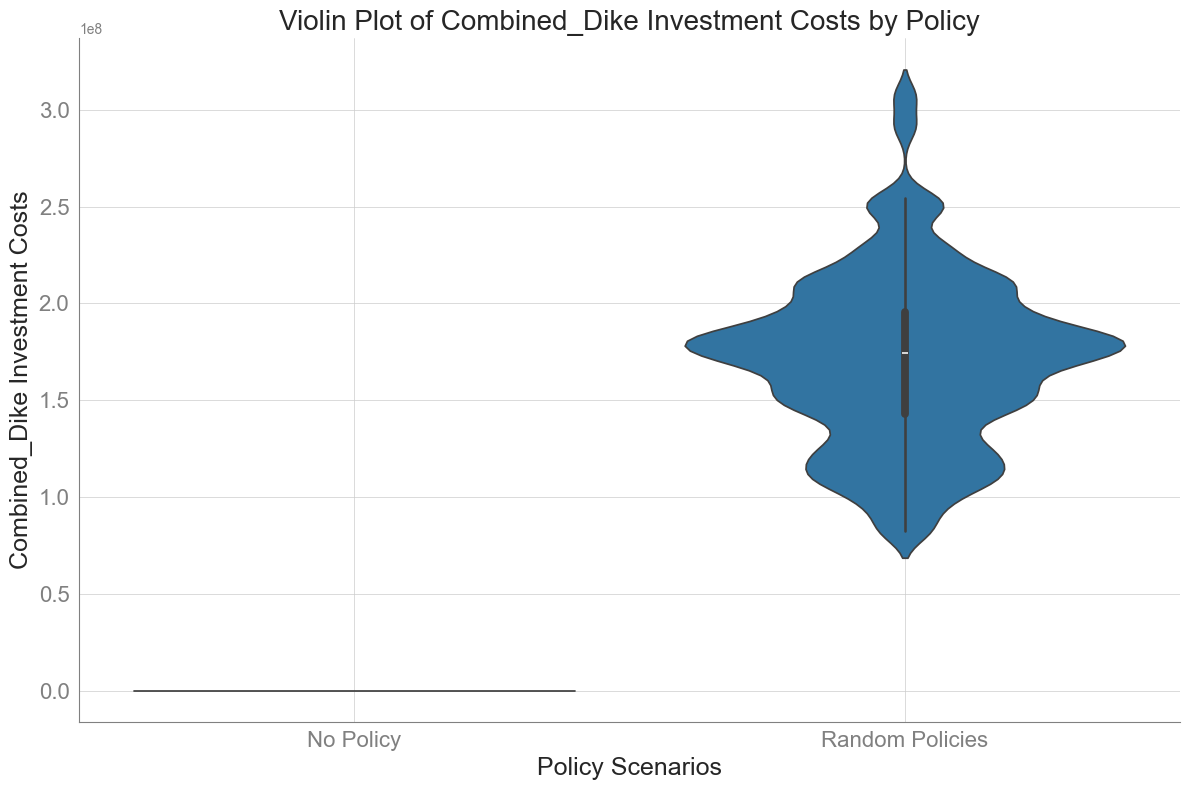

Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\data\plots\Violin Plot of Combined_Expected Annual Damage.png


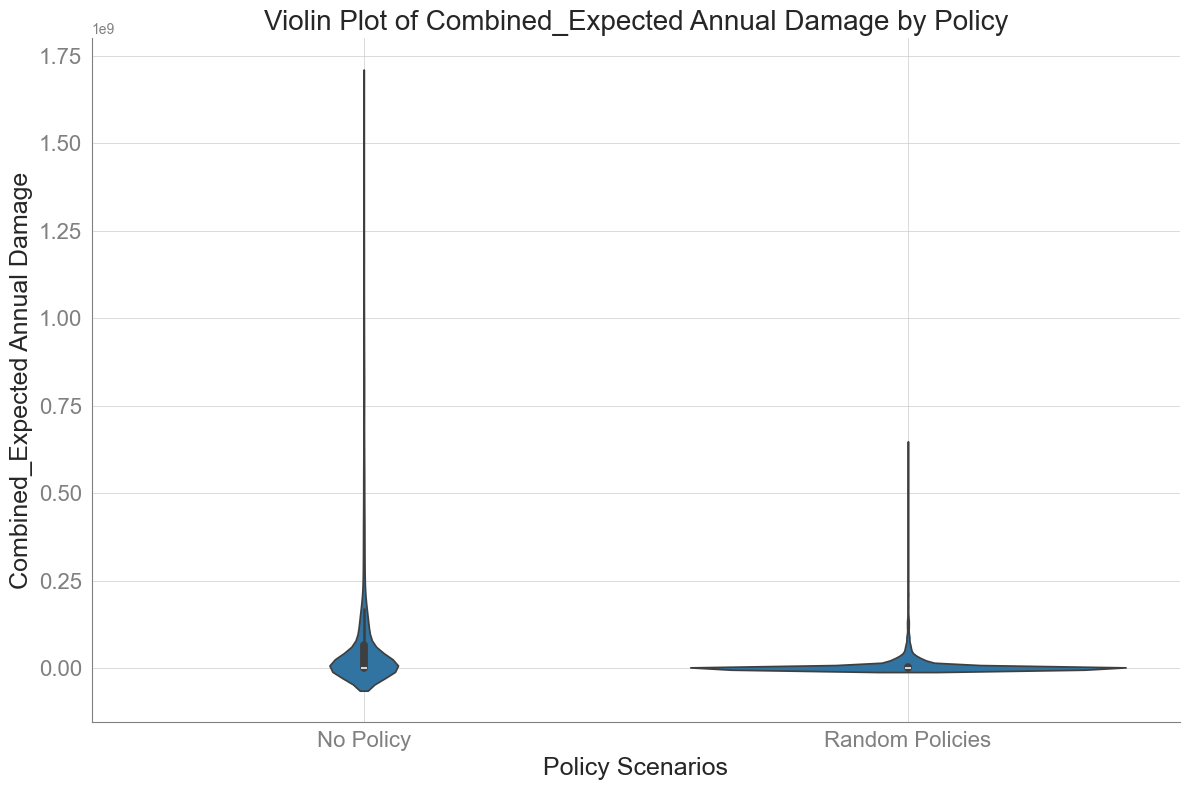

In [119]:
# Selecting the columns to plot
columns_to_plot = [
    'Combined_Expected Number of Deaths',
    'Combined_Dike Investment Costs',
    'Combined_Expected Annual Damage'
]

# Combining the dataframes for the violin plot
combined_df = pd.concat([
    no_policy_outcomes_df[columns_to_plot].melt(var_name='Outcome', value_name='Value').assign(Policy='No Policy'),
    random_outcomes_df[columns_to_plot].melt(var_name='Outcome', value_name='Value').assign(Policy='Random Policies')
])

current_dir = os.getcwd()

# Plotting the violin plots for each outcome separately
for outcome in columns_to_plot:
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Policy', y='Value', data=combined_df[combined_df['Outcome'] == outcome])
    plt.title(f'Violin Plot of {outcome} by Policy')
    plt.xlabel('Policy Scenarios')
    plt.ylabel(outcome)
    customize_save_and_show_plot(f'Violin Plot of {outcome}')
    plt.show()

# 2. Runs with No Policy

In this section, we analyze scenarios where no specific policies are implemented. Instead, we explore the uncertainty space by varying uncertainties within 10,000 different combinations. This allows us to understand the model's behavior under different conditions without any policy interventions. We will perform five key analyses: visualizing the scenarios using a seaborn pairplot, feature scoring, dimensional stacking, PRIM, and sensitivity analysis.

## 2.1. Pairplot

We begin by visualizing the relationships between different outcome variables using a pairplot. A pairplot allows us to see pairwise relationships in a dataset. It helps in identifying correlations and distributions, making it easier to understand how different uncertainties and outcomes interact with each other in the absence of any policies.

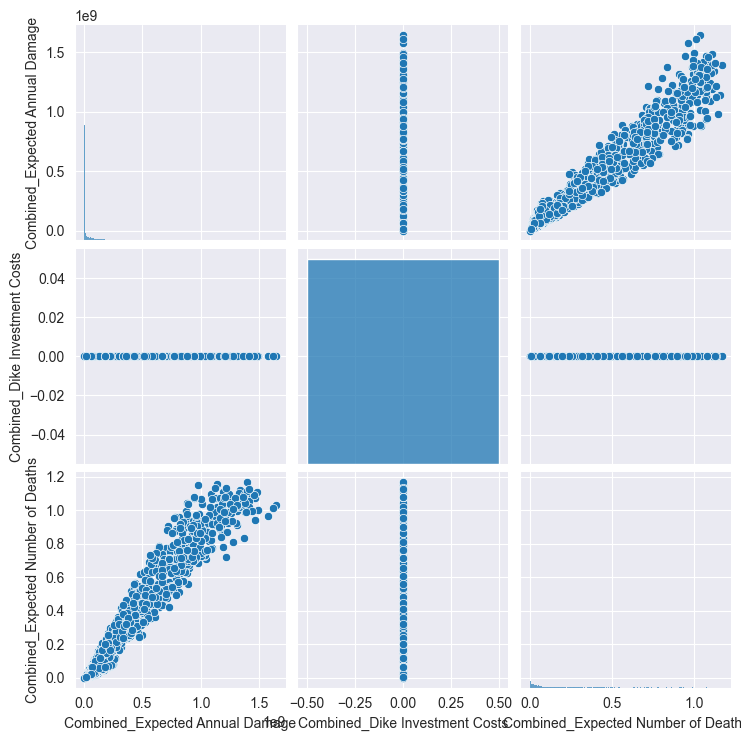

In [41]:
# Create multi scatter plot for zero policy combined
sns.pairplot(no_policy_combined)
plt.show()

The plot above shows us that when no policy is applied, and the scenarios are varied; it is clearly visible that an increase in number of deaths and annual damage, usually go hand in hand. Furthermore, the other two outputs don't tell us a lot, as there are no policies applied, and therefore the investment cost will always be zero, resulting in a vertical/horizontal spread across 0.

We will now plot the outcomes for the individual dike rings. As seen above investment cost will always be zero, and will therefore be excluded from this pairplot to create a better overview.  

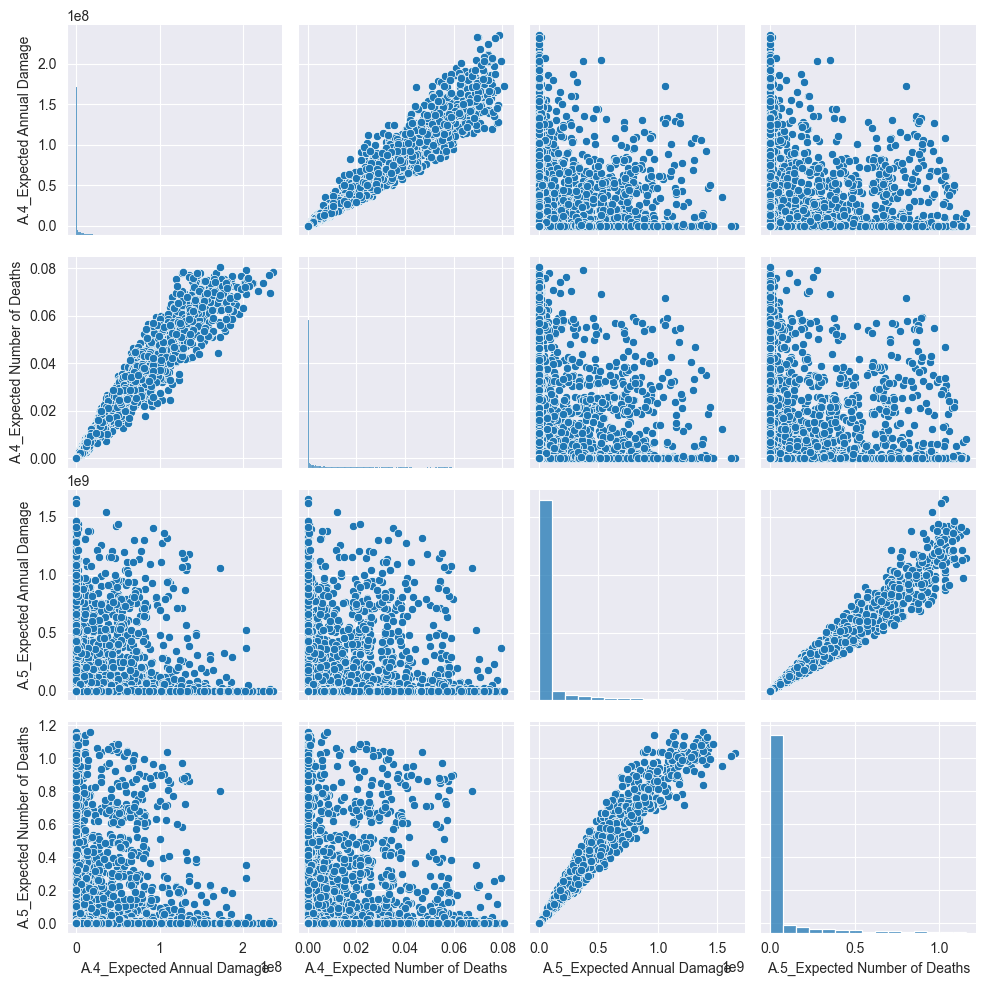

In [43]:
# Create multi scatter plot for zero policy separate
sns.pairplot(no_policy_separate[['A.4_Expected Annual Damage',
       'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage',
       'A.5_Expected Number of Deaths']])
plt.show()

explanation ...........

## 2.2. Feature Scoring
Next, we assess the importance of different features using feature scoring methods. Feature scoring helps in quantifying the influence of various uncertainties on the outcomes. We start by initializing the dike model and accessing the uncertainties. Then, we calculate feature scores to understand their impact on the outcomes of interest.

In [44]:
# Initialize the dike model from the problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Access and print the uncertainties
dike_model_uncertainties = dike_model.uncertainties

# Create a list of uncertainty names
uncertainties = []

# Print out each uncertainty in the list
for uncertainty in dike_model_uncertainties:
    uncertainties.append(uncertainty.name)
    
print(uncertainties)  

['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']


We extract the relevant uncertainties from the no policy experiments DataFrame. This isolates the variables that will be used for feature scoring.

In [45]:
no_policy_experiments_uncertainties = no_policy_experiments_df.loc[:,uncertainties]

print(no_policy_experiments_uncertainties)

      discount rate 0  discount rate 1  discount rate 2  \
0                 1.5              2.5              2.5   
1                 3.5              3.5              3.5   
2                 4.5              1.5              1.5   
3                 3.5              2.5              4.5   
4                 1.5              4.5              1.5   
...               ...              ...              ...   
9995              2.5              1.5              2.5   
9996              2.5              4.5              2.5   
9997              3.5              3.5              4.5   
9998              3.5              4.5              3.5   
9999              3.5              4.5              2.5   

      A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                         102  103.067300   0.853805        1.0   57.843392   
1                         100  298.489103   0.689545        1.0   80.766722   
2                          35  191.011125   0.079419  

We now calculate the scores for each uncertainty, indicating how strongly each one affects the various outcomes. The heatmap visually represents these scores, with higher scores indicating a greater impact.

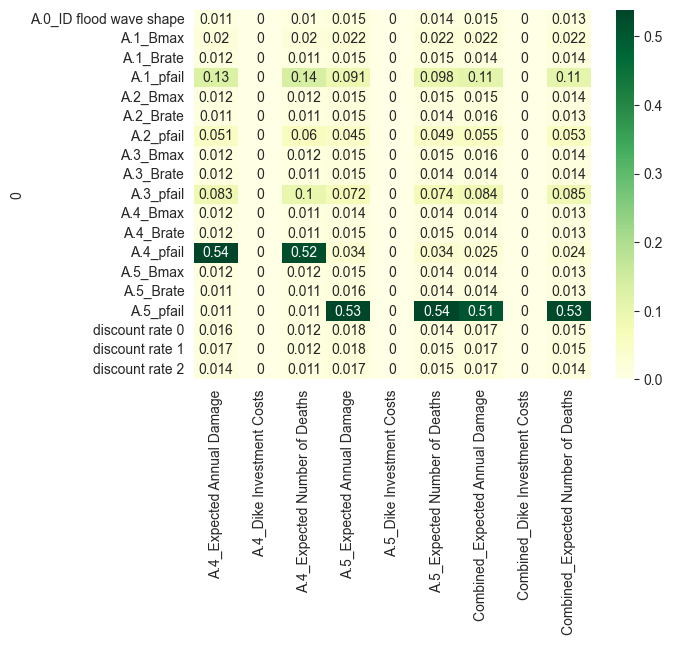

In [46]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(no_policy_experiments_uncertainties, no_policy_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

write a text explaining how dike ring 4 and 5 should look at different pfails as the biggest influence on annual damage and expected number of deaths. for the waterboard mainly a5 has the strongest influence on these variables. ..............

## 2.3. Dimensional Stacking

We will now use dimensional stacking to understand multi-dimensional interactions between features and outcomes. This technique helps in visualizing how different combinations of uncertainties influence a specific outcome variable.

This method creates a multi-dimensional pivot plot, showing how different levels of uncertainties interact to produce high values of a particular outcome (in this case, the ... percentile of ...). It helps in identifying significant combinations of uncertainties that lead to extreme outcomes.

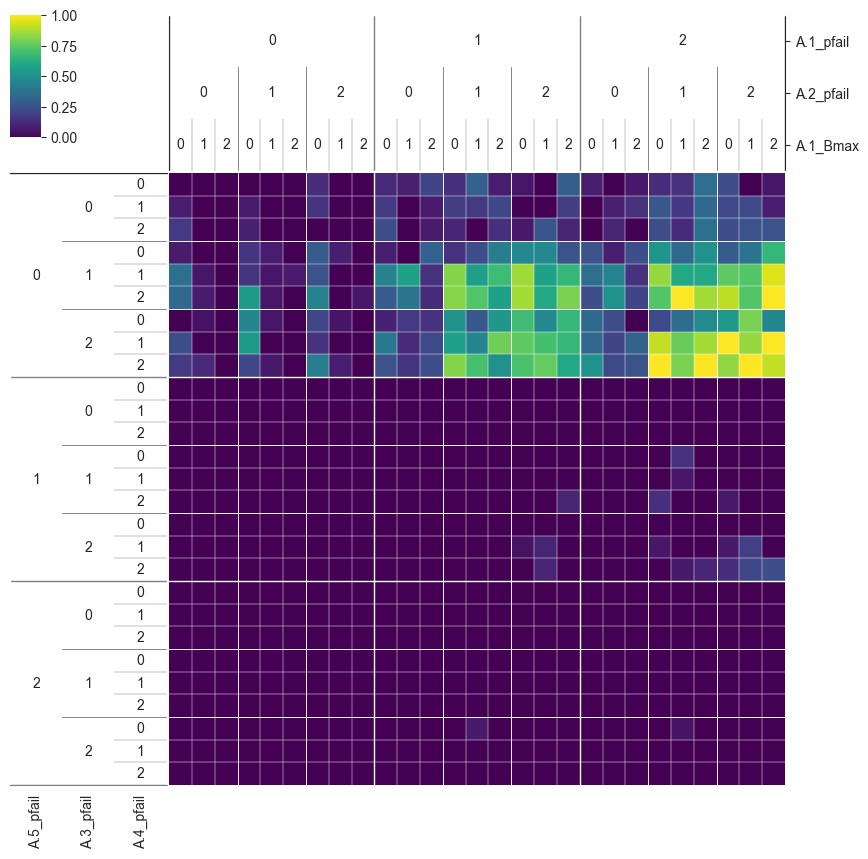

In [51]:
x_no_policy = no_policy_experiments_uncertainties
damage_no_policy = no_policy_outcomes_df['Combined_Expected Annual Damage'].values > np.percentile(no_policy_outcomes_df['Combined_Expected Annual Damage'],90)

dimensional_stacking.create_pivot_plot(x_no_policy,damage_no_policy, nr_levels=3)
plt.show()

write a text interpreting this diagram ....

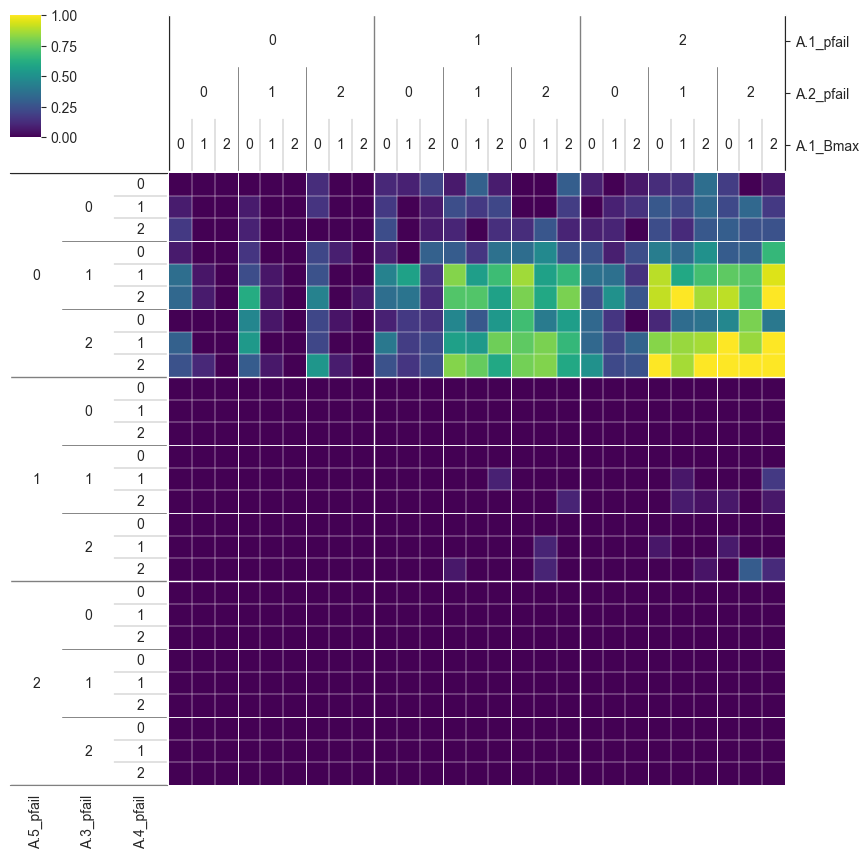

In [52]:
x_no_policy = no_policy_experiments_uncertainties
deaths_no_policy = no_policy_outcomes_df['Combined_Expected Number of Deaths'].values > np.percentile(no_policy_outcomes_df['Combined_Expected Number of Deaths'],90)

dimensional_stacking.create_pivot_plot(x_no_policy,deaths_no_policy, nr_levels=3)
plt.show()

Explain this plot in depth .........

say it kind of looks the same

## 2.4. PRIM
PRIM (Patient Rule Induction Method) will now be used to identify regions in the data that lead to specific outcomes. By focusing on the worst-case scenarios, we can understand which combinations of uncertainties are most critical. We apply PRIM to the 10% worst outcomes for x variable ...., identifying the regions (or "boxes") in the uncertainty space that lead to these extreme outcomes.

### 2.4.1. Expected Annual Damage
We apply the PRIM algorithm to identify regions in the data with the highest expected annual damage. The threshold and peel_alpha parameters control the sensitivity of the algorithm in identifying significant regions.

In [66]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, damage_no_policy, threshold=0.8, peel_alpha= 0.1)
box1 = prim_alg.find_box()

We will now make a plot that shows the trade-off between coverage (the proportion of cases captured by the box) and density (the proportion of cases within the box that meet the criterion). Annotating the plot helps in selecting the optimal box for further analysis.

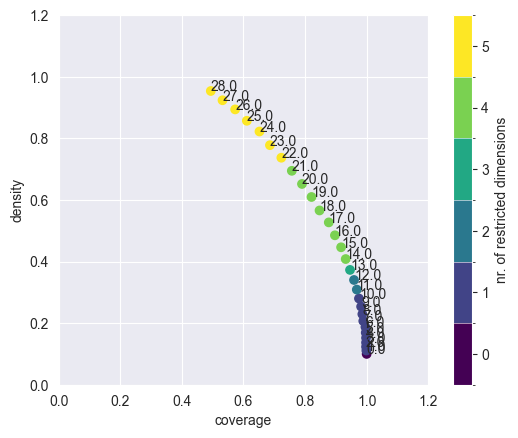

In [67]:
# Let's show the created boxes
box1.show_tradeoff(annotated=True)
plt.show()

Explain which box we will choose to analyze further...

We will choose box 21 this one has 4 dimensions bla bla bla

We inspect the selected box to understand the characteristics of the uncertainties within this region. This helps in identifying the critical combinations of uncertainties.

In [68]:
# Box X has been selected due to the +/- 80% density
box_number_of_choice = 21
box1.inspect(box_number_of_choice)[0]

coverage       0.757000
density        0.694495
id            21.000000
k            757.000000
mass           0.109000
mean           0.694495
n           1090.000000
res_dim        4.000000
Name: 21, dtype: float64

             box 21                                       
                min       max      qp value       qp value
A.5_pfail  0.000037  0.254042           NaN  7.789164e-271
A.1_pfail  0.340396  0.999990  4.169379e-36            NaN
A.3_pfail  0.201724  0.999902  2.234203e-14            NaN
A.2_pfail  0.205045  0.999940  4.604356e-12            NaN


Let's now create a graphical representation of the selected box to provide a clearer view of the significant uncertainties and their ranges.

[<Figure size 640x480 with 1 Axes>]

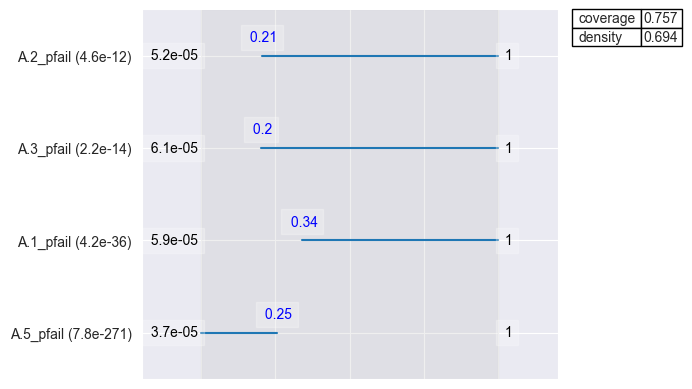

In [69]:
box1.inspect(box_number_of_choice, style="graph")

This plot shows the relationships between pairs of uncertainties within the selected box, helping to visualize the interactions that lead to extreme outcomes.

This step verifies the robustness of the selected box by resampling and checking if the coverage and density remain consistent. High reproducibility indicates that the identified region is reliable.

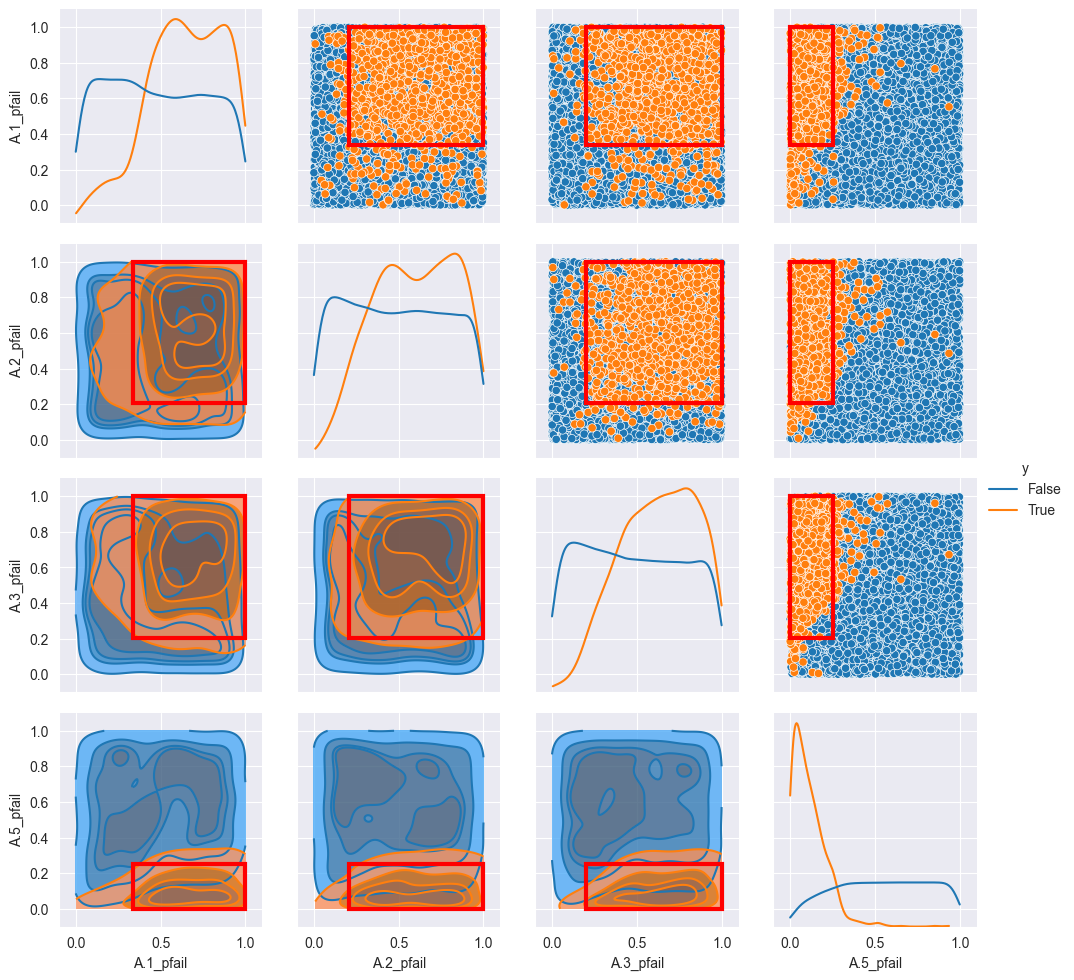

In [70]:
box1.show_pairs_scatter(box_number_of_choice)
plt.show()

#### Let us resample

In [71]:
box1.resample(box_number_of_choice)

reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.2_pfail                             100.0              100.0
A.3_pfail                             100.0              100.0
A.5_pfail                             100.0              100.0
A.4_pfail                              50.0               40.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0

The first X parameters can exactly reproduce coverage and density, confirming the suggestion of highly significant quasi p values. The third and fourth are also relatively reliable given their values with an average of 90 and 65 for reproducability.  


### 2.4.2. Expected Annual Deaths

In [74]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, deaths_no_policy, threshold=0.8, peel_alpha= 0.1)
box2 = prim_alg.find_box()

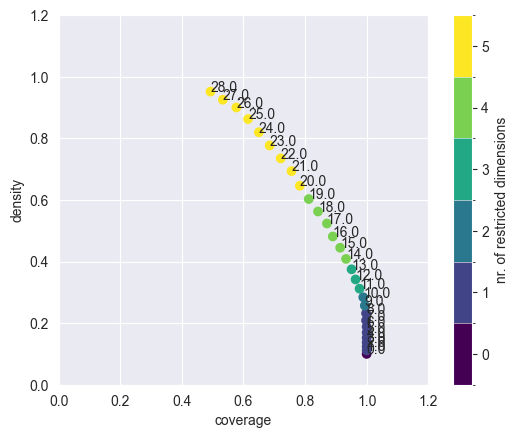

In [75]:
# Let's show the created boxes
box2.show_tradeoff(annotated=True)
plt.show()

In [79]:
# Box X has been selected due to the +/- 80% density
box2_number_of_choice = 19
box2.inspect(box2_number_of_choice)[0]

coverage       0.812000
density        0.602821
id            19.000000
k            812.000000
mass           0.134700
mean           0.602821
n           1347.000000
res_dim        4.000000
Name: 19, dtype: float64

             box 19                                       
                min       max      qp value       qp value
A.5_pfail  0.000037  0.280411           NaN  2.394125e-254
A.1_pfail  0.346225  0.999990  4.854107e-32            NaN
A.3_pfail  0.195841  0.999902  6.777333e-12            NaN
A.2_pfail  0.103421  0.999940  5.368215e-05            NaN


[<Figure size 640x480 with 1 Axes>]

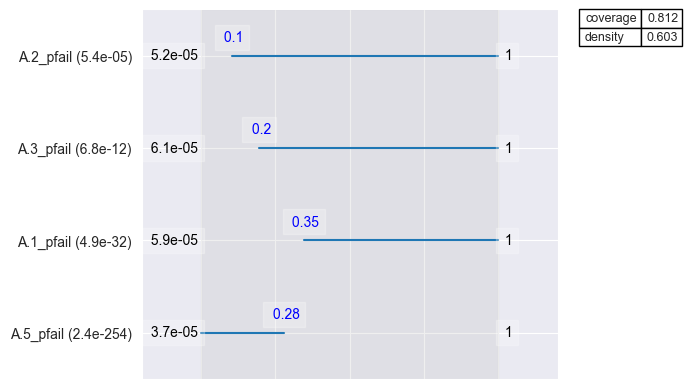

In [80]:
box2.inspect(box2_number_of_choice, style="graph")

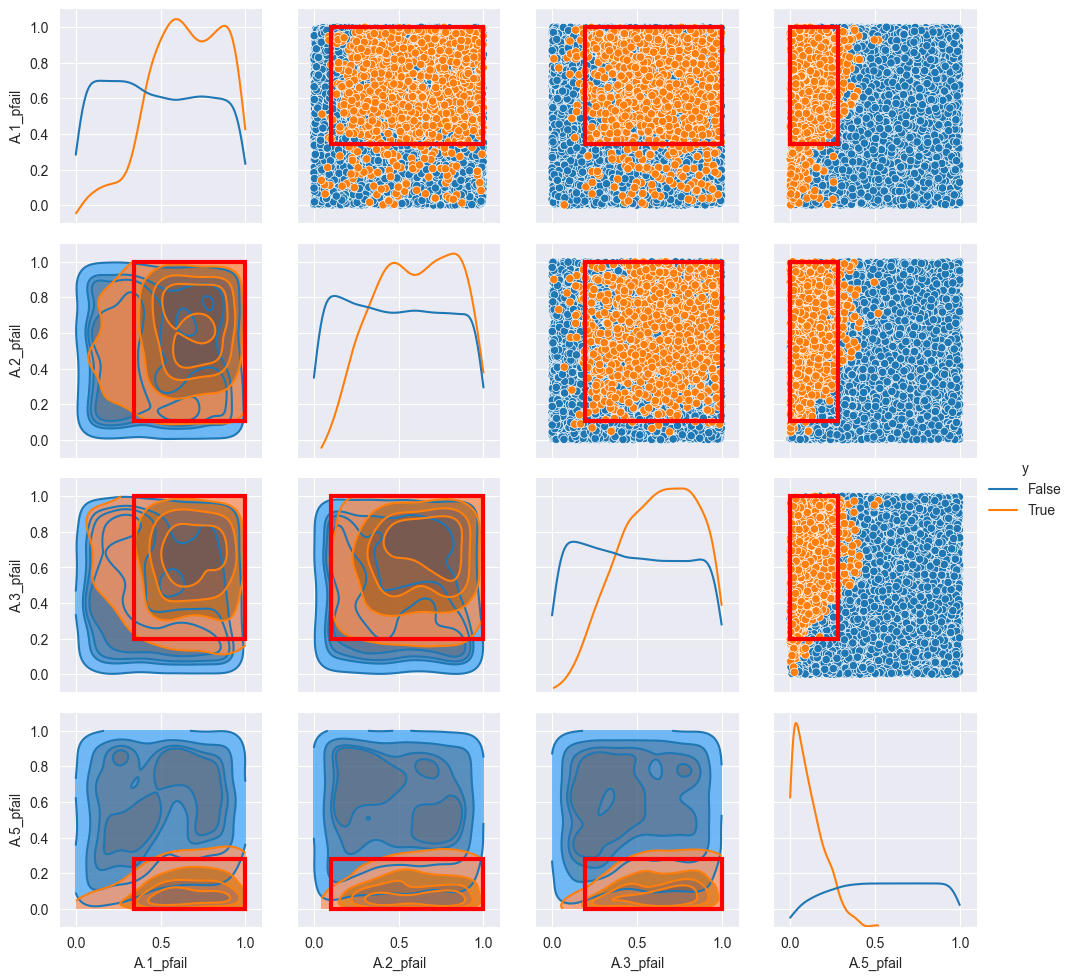

In [81]:
box2.show_pairs_scatter(box2_number_of_choice)
plt.show()

In [82]:
box2.resample(box2_number_of_choice)

reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.2_pfail                             100.0              100.0
A.3_pfail                             100.0              100.0
A.5_pfail                             100.0              100.0
A.4_pfail                              50.0               50.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0

# 3. 200 Policy Runs --> Think about which policies (maybe the water board is not open to all policies (do they want RfR, or do they want higher dikes? or both not))

We will now look at 200 ... different policies under 1,000 ... different scenarios to create insight into 200,000 potential futures. We will again apply the five different methods that we used in step 2 above. Since the inherent goals of these methods have already been discussed, this section will focus on the outcomes of the analyses.


## 3.1. Pairplot

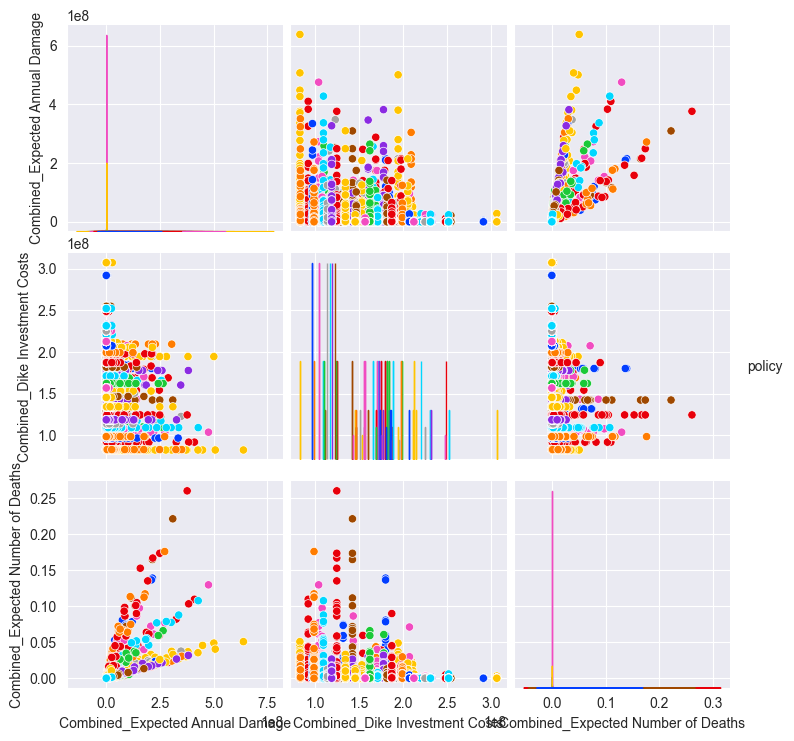

In [83]:
# Create multi scatter plot for zero policy
sns.pairplot(random_outcomes_combined, hue='policy', plot_kws={'legend': None}, palette='bright')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

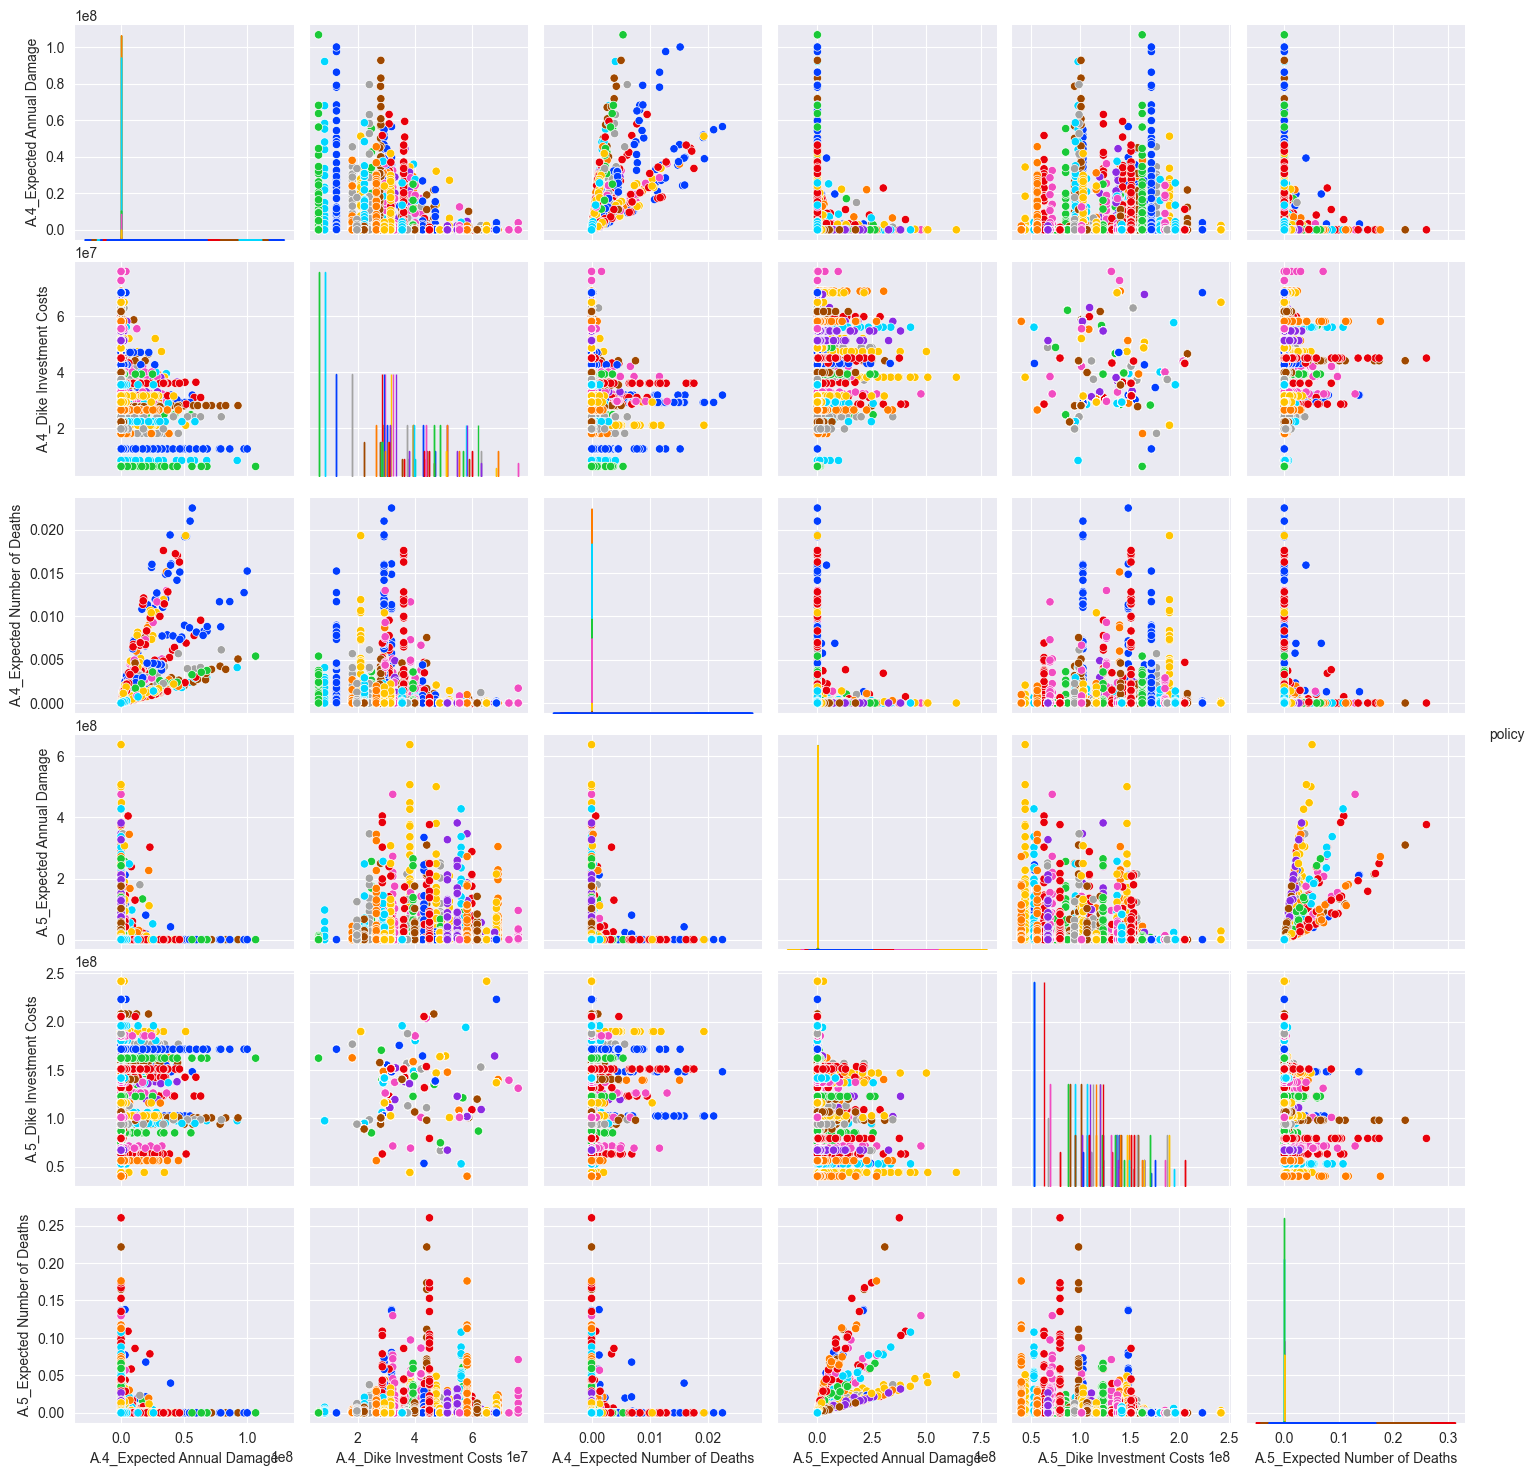

In [84]:
# Create multi scatter plot for zero policy
sns.pairplot(random_outcomes_separate, hue='policy', plot_kws={'legend': None}, palette='bright')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

## 3.2. Feature Scoring

In [86]:
random_experiments_uncertainties = random_experiments_df.loc[:,uncertainties]

print(random_experiments_uncertainties)

      discount rate 0  discount rate 1  discount rate 2  \
0                 1.5              2.5              1.5   
1                 4.5              2.5              1.5   
2                 1.5              1.5              3.5   
3                 4.5              3.5              3.5   
4                 4.5              3.5              3.5   
...               ...              ...              ...   
9995              1.5              3.5              2.5   
9996              2.5              2.5              4.5   
9997              4.5              2.5              3.5   
9998              3.5              1.5              3.5   
9999              3.5              4.5              2.5   

      A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                         122  175.094121   0.274331       10.0  298.220877   
1                           3  287.068670   0.247375        1.5  286.365450   
2                          78  285.204456   0.095137  

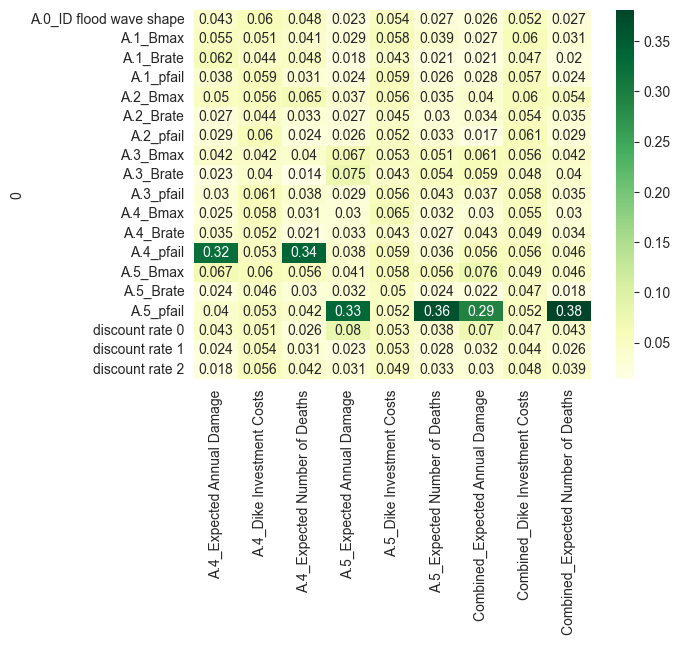

In [87]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(random_experiments_uncertainties, random_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

describe how the same uncertainties, still ahve the biggest influence on the outcomes. however their effect on the outcomes has become less pronounced, and other uncertainties, have gained more influence on the variance of the outputs of interest .....

## 3.3. Dimensional Stacking

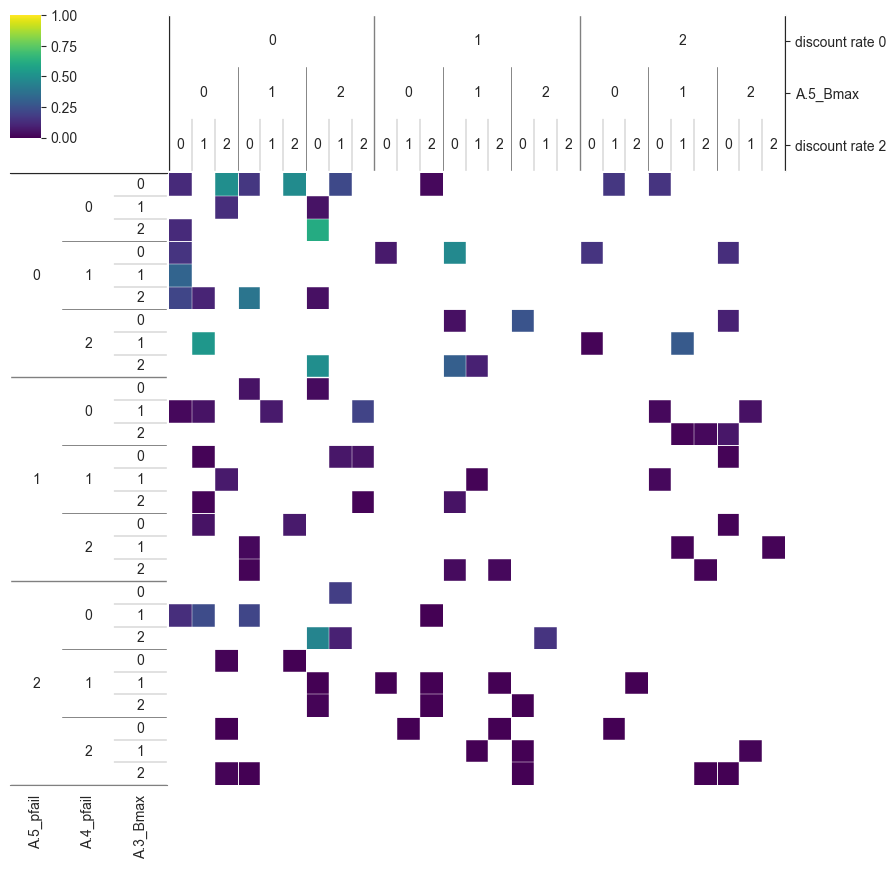

In [91]:
x_random_policy = random_experiments_uncertainties
damage_random_policy = random_outcomes_df['Combined_Expected Annual Damage'].values > np.percentile(random_outcomes_df['Combined_Expected Annual Damage'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,damage_random_policy, nr_levels=3)
plt.show()

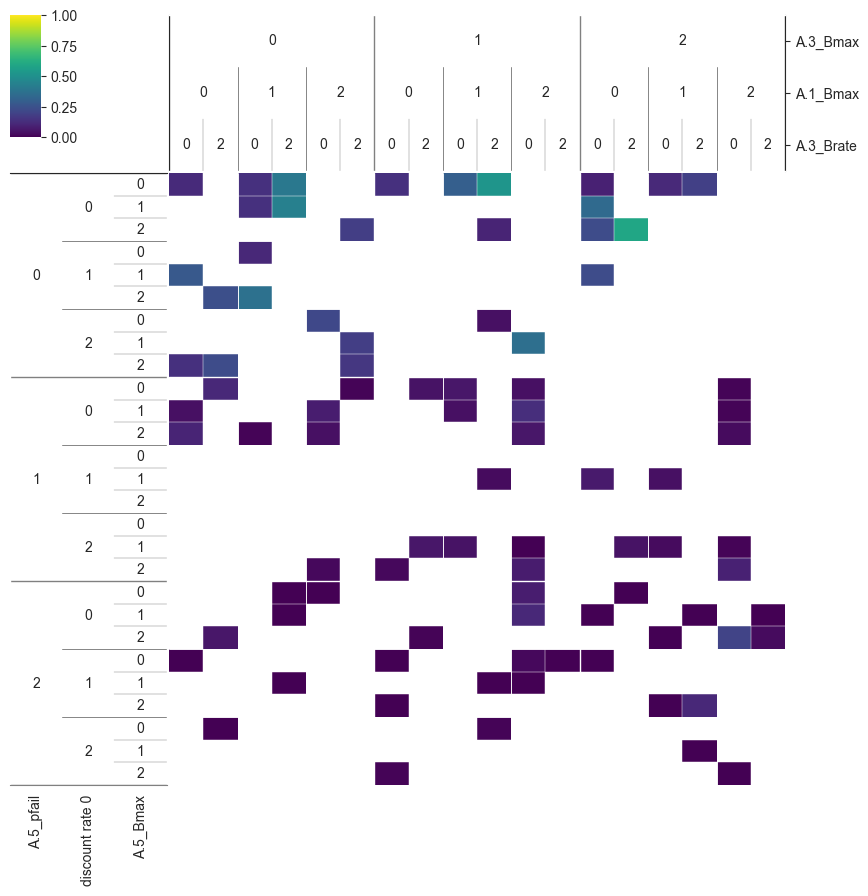

In [92]:
x_random_policy = random_experiments_uncertainties
deaths_random_policy = random_outcomes_df['Combined_Expected Number of Deaths'].values > np.percentile(random_outcomes_df['Combined_Expected Number of Deaths'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,deaths_random_policy, nr_levels=3)
plt.show()

## 2.4. PRIM
### 2.4.1. Expected Annual Damage

In [105]:
# applying PRIM to the 10% worst outcomes for the expected annual damage (highest damage costs)
prim_alg = prim.Prim(x_random_policy, damage_random_policy, threshold=0.5, peel_alpha= 0.1)
box3 = prim_alg.find_box()

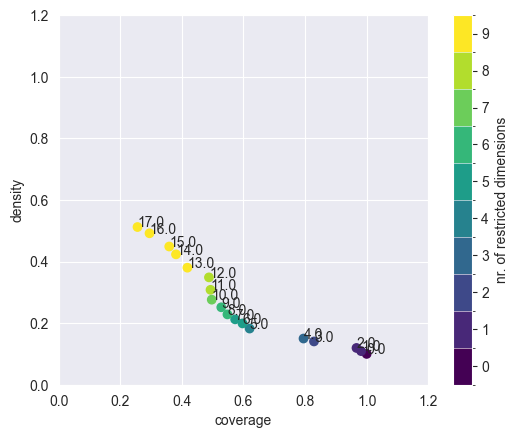

In [106]:
# Let's show the created boxes
box3.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

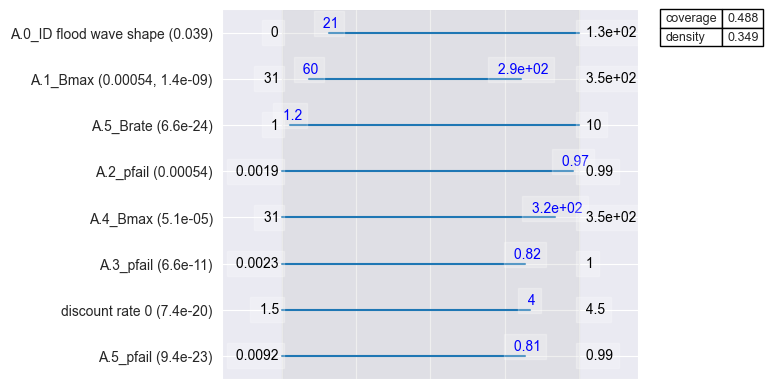

In [107]:
box3_number_of_choice = 12
box3.inspect(box3_number_of_choice, style="graph")

In [108]:
box3.show_pairs_scatter(box3_number_of_choice)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000022059089EE0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

#### Let us resample

In [ ]:
box3.resample(box3_number_of_choice)

### 3.4.2. Expected Number of Deaths 

In [ ]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_random_policy, deaths_random_policy, threshold=0.5, peel_alpha= 0.1)
box4 = prim_alg.find_box()

In [ ]:
# Let's show the created boxes
box4.show_tradeoff(annotated=True)
plt.show()

In [ ]:
box4_number_of_choice = 12
box4.inspect(box4_number_of_choice, style="graph")

In [ ]:
box4.show_pairs_scatter(box4_number_of_choice)
plt.show()

#### Let us resample

In [ ]:
box4.resample(box3_number_of_choice)

# 4. Sensitivity Analysis
In this section, we conduct a sensitivity analysis using the Sobol method. The Sobol sensitivity analysis is a global sensitivity analysis technique that quantifies the contribution of input variables to the variance in the output. This helps us understand which uncertainties have the most significant impact on the model outcomes. We will follow a systematic approach to perform this analysis and visualize the results.

In [109]:
# Define the problem for the Sobol sensitivity analysis using the dike model uncertainties
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


We extract the relevant uncertainties from the Sobol experiments DataFrame, isolating the variables that will be used in the sensitivity analysis.

In [112]:
# Extract uncertainties from the Sobol experiments DataFrame
sobol_experiments_uncertainties = sobol_experiments_df.loc[:,uncertainties]
print(sobol_experiments_uncertainties.columns)

Index(['discount rate 0', 'discount rate 1', 'discount rate 2',
       'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate',
       'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail',
       'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax',
       'A.5_pfail', 'A.5_Brate'],
      dtype='object')


We iterate over each unique policy in the Sobol experiments, performing the Sobol sensitivity analysis on variable xx ..... The results are stored and plotted to visualize the contribution of each uncertainty.

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

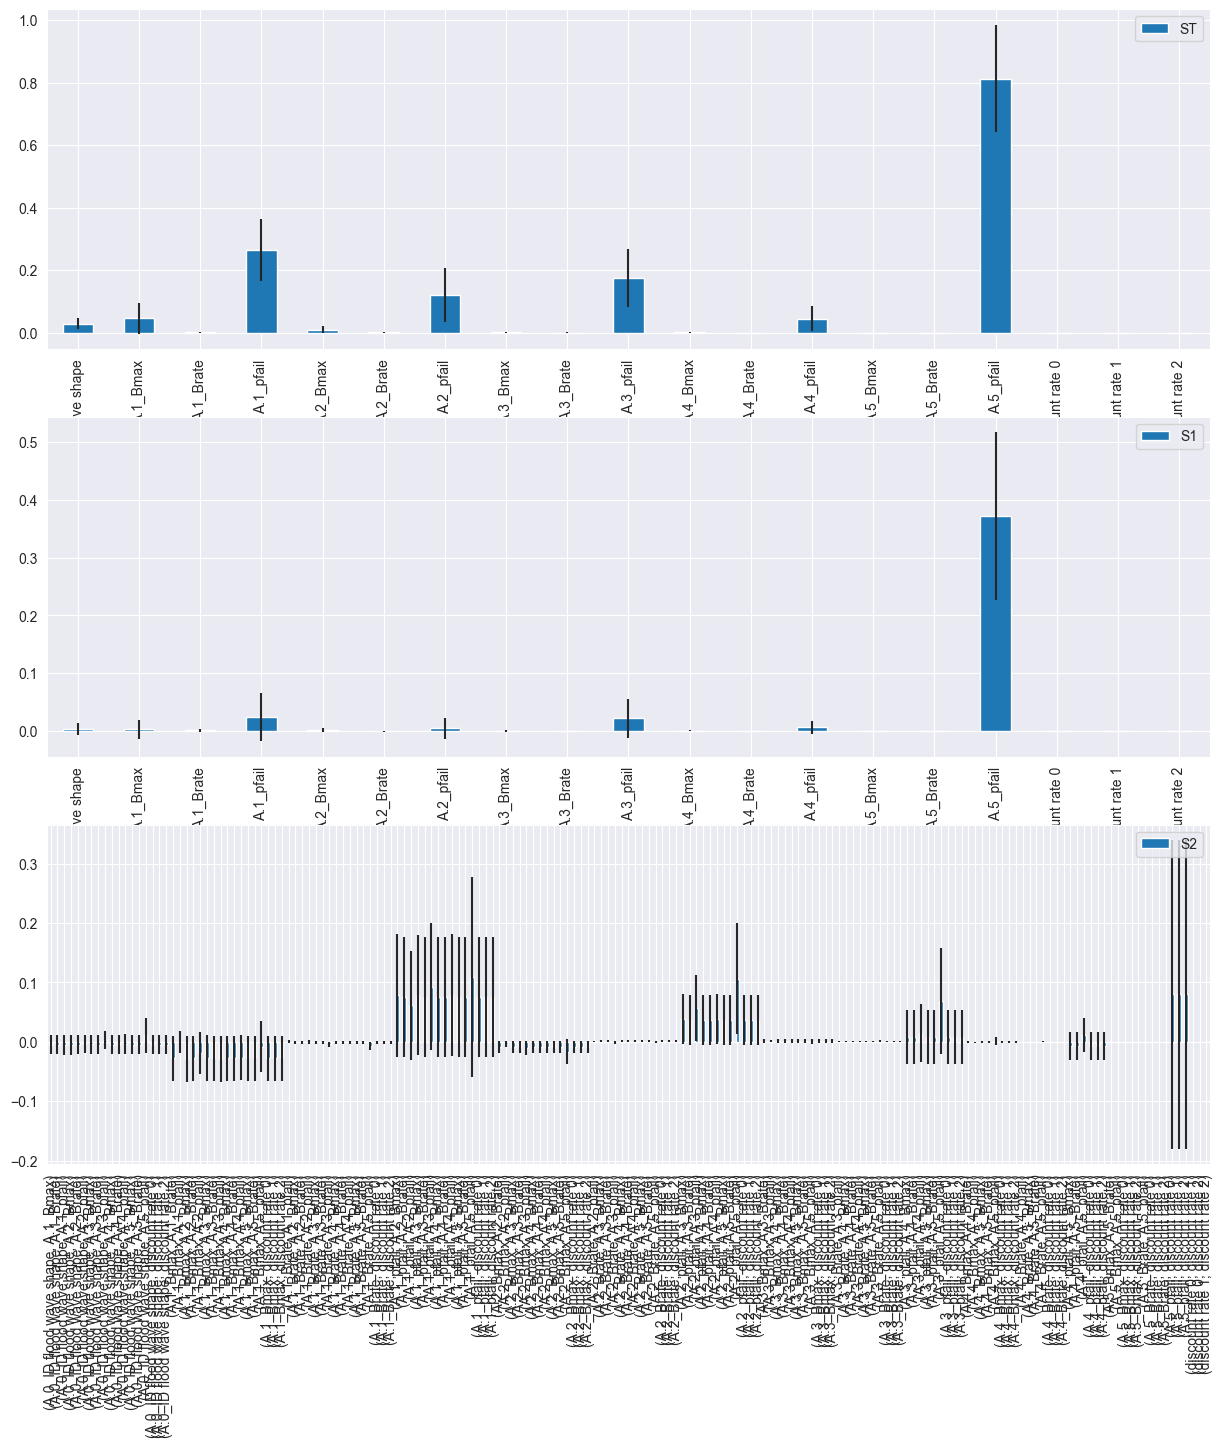

In [113]:
# Perform Sobol sensitivity analysis for each policy and plot the results
sobol_results = {}

for policy in sobol_experiments_df.policy.unique():
    logical = sobol_experiments_df.policy == policy
    y = sobol_outcomes_df.loc[logical,'Combined_Expected Number of Deaths'].values
    indices = analyze(problem, y)
    sobol_results[policy] = indices

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 15)
indices.plot(ax=axes)

This function performs the Sobol sensitivity analysis for a specified outcome variable and plots the results. The function calculates the Sobol indices, filters them to the relevant metrics, and visualizes them using a bar plot.

In [115]:
# Define a function to perform Sobol sensitivity analysis and plot the results for a specified outcome variable
def sobol_sensitivity_analysis(outcome_variable, sobol_outcomes, problem):
    """
    Perform Sobol sensitivity analysis for a specified outcome variable and plot the results.

    Parameters
    ----------
    outcome_variable : str
        The name of the outcome variable to analyze.
    sobol_outcomes : pd.DataFrame
        DataFrame containing the outcomes from the Sobol sensitivity analysis.
    problem : dict
        The problem definition for SALib.
    
    Returns
    -------
    Si : dict
        The Sobol sensitivity indices.
    """
    # Calculate mean and standard deviation for the specified outcome variable
    outcome_value = sobol_outcomes[outcome_variable].values

    # Perform Sobol analysis
    Si = sobol.analyze(problem, outcome_value, calc_second_order=True, print_to_console=True)

    # Filter Sobol indices to relevant metrics
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    # Plot Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

    return Si

We apply the Sobol sensitivity analysis function to the 'A.4_Expected Number of Deaths' outcome variable. This helps in understanding which uncertainties most significantly affect the expected number of deaths.

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.028405  0.017432
A.1_Bmax                 0.045284  0.051136
A.1_Brate                0.000464  0.000435
A.1_pfail                0.263437  0.112265
A.2_Bmax                 0.009251  0.008983
A.2_Brate                0.000183  0.000172
A.2_pfail                0.120233  0.083252
A.3_Bmax                 0.001066  0.000995
A.3_Brate                0.000088  0.000140
A.3_pfail                0.173479  0.093497
A.4_Bmax                 0.000227  0.000291
A.4_Brate                0.000003  0.000005
A.4_pfail                0.043894  0.045707
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.813314  0.151831
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.003330  0.012177
A.1_Bmax                 0.00257

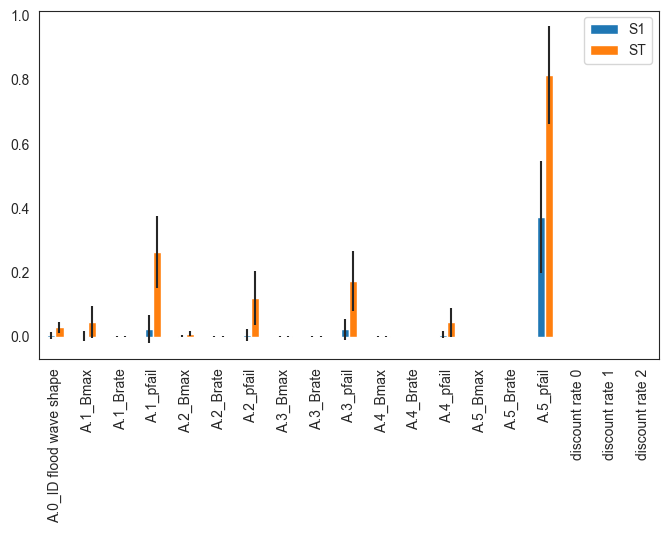

{'S1': array([ 3.33045861e-03,  2.57327499e-03,  9.35956585e-04,  2.40919123e-02,
         1.89634932e-03, -5.23045777e-04,  4.30956009e-03, -5.73209847e-04,
        -1.46871059e-04,  2.20261477e-02,  9.22966293e-05,  2.03475702e-05,
         5.86349417e-03,  0.00000000e+00,  0.00000000e+00,  3.72180178e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'S1_conf': array([1.21766118e-02, 1.52398986e-02, 2.29375558e-03, 4.32417733e-02,
        3.83846442e-03, 7.52236304e-04, 1.93613782e-02, 1.59299819e-03,
        4.51416402e-04, 3.30781590e-02, 6.13354984e-04, 5.67979679e-05,
        1.14464485e-02, 0.00000000e+00, 0.00000000e+00, 1.72896528e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'ST': array([2.84045526e-02, 4.52843703e-02, 4.63899294e-04, 2.63436525e-01,
        9.25148301e-03, 1.82583831e-04, 1.20233163e-01, 1.06624687e-03,
        8.78643890e-05, 1.73478997e-01, 2.27476243e-04, 2.65565128e-06,
        4.38935273e-02, 0.00000000e+00, 0.00000000

In [116]:
# Perform Sobol sensitivity analysis for the outcome variable 'A.4_Expected Number of Deaths'
outcome_variable = 'Combined_Expected Number of Deaths'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.033221  0.022949
A.1_Bmax                 0.046201  0.048752
A.1_Brate                0.000457  0.000439
A.1_pfail                0.249145  0.082500
A.2_Bmax                 0.006913  0.008165
A.2_Brate                0.000187  0.000158
A.2_pfail                0.101085  0.066361
A.3_Bmax                 0.001085  0.000985
A.3_Brate                0.000083  0.000140
A.3_pfail                0.169679  0.089653
A.4_Bmax                 0.000220  0.000319
A.4_Brate                0.000002  0.000004
A.4_pfail                0.044209  0.031687
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.777561  0.176316
discount rate 0          0.006441  0.003445
discount rate 1          0.010266  0.004780
discount rate 2          0.006606  0.003962
                               S1   S1_conf
A.0_ID flood wave shape  0.002558  0.012684
A.1_Bmax                 0.00507

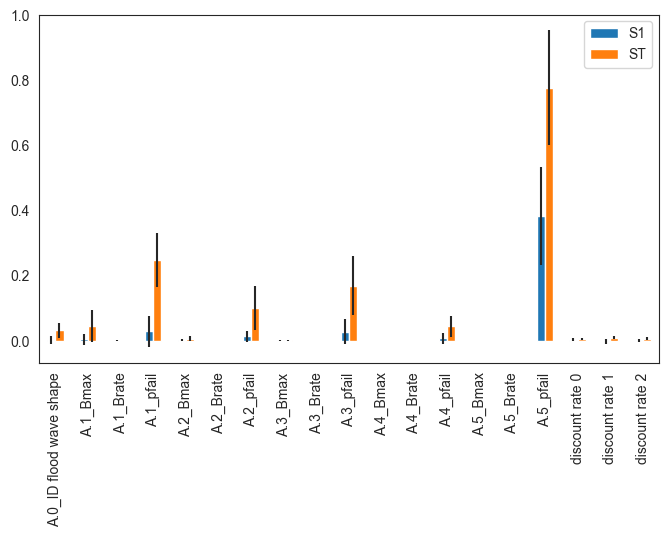

{'S1': array([ 2.55769237e-03,  5.06959484e-03,  7.47719451e-04,  2.98504897e-02,
         2.92919081e-03, -4.65134812e-04,  1.38745507e-02,  1.63554836e-04,
        -1.42969961e-04,  2.81327590e-02, -2.89954011e-05,  1.24931904e-05,
         7.78895626e-03,  0.00000000e+00,  0.00000000e+00,  3.84134518e-01,
         3.31413032e-03, -1.37909793e-03, -1.40379005e-04]),
 'S1_conf': array([1.26835084e-02, 1.73493061e-02, 2.16178892e-03, 4.78646356e-02,
        3.20390780e-03, 7.52605547e-04, 1.70088920e-02, 1.64633371e-03,
        5.29716063e-04, 3.92350126e-02, 5.67626191e-04, 3.06123622e-05,
        1.74431374e-02, 0.00000000e+00, 0.00000000e+00, 1.49907846e-01,
        4.99049616e-03, 7.95987399e-03, 4.51537481e-03]),
 'ST': array([3.32214590e-02, 4.62012523e-02, 4.57080863e-04, 2.49145080e-01,
        6.91330244e-03, 1.87258002e-04, 1.01084533e-01, 1.08529263e-03,
        8.31066876e-05, 1.69678584e-01, 2.19946046e-04, 2.40453970e-06,
        4.42090247e-02, 0.00000000e+00, 0.00000000

In [118]:
# Perform Sobol sensitivity analysis for the outcome variable 'A.4_Expected Number of Deaths'
outcome_variable = 'Combined_Expected Annual Damage'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)
